In [1]:
import ast
import json
import requests

from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm

# space-hosting preparation

Firstly we need to clone `space-hosting` from github:

`git clone https://github.com/kontur-model-ops/space-hosting.git`

Then let's define path to space-hosting data directory.

In [2]:
space_hosting_data_path = Path('space-hosting/.data-samples')

# Hotel Reviews Data in Europe

In presented notebook we will use Hotel Reviews Data in Europe dataset for searching hotels by user's query. For each hotel in dataset we will create a vector. That vector will be an average of all hotel's review vectors.
At the end we will try to find hotels suitable to some user's query using Space-Hosting.

Dataset - https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe

We need to download it and put to `./data` directory.

## Data loading

In [3]:
hotel_reviews = pd.read_csv('data/Hotel_Reviews.csv')
hotel_reviews.shape

(515738, 17)

## EDA

### Hotel statistics

Number of hotels.

In [4]:
hotel_reviews.Hotel_Name.nunique()

1492

Hotel average score histogram.

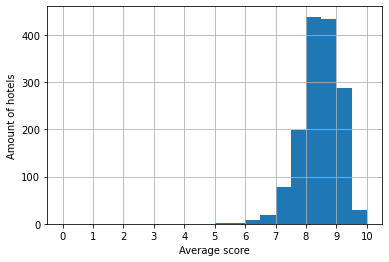

In [5]:
hotel_reviews.groupby('Hotel_Name')['Reviewer_Score'].mean().hist(bins=20, range=[0, 10])
plt.xticks(range(0, 11))
plt.xlabel('Average score')
plt.ylabel('Amount of hotels')
plt.show()

### Hotel Locations

In [6]:
cities = hotel_reviews['Hotel_Address'].str.split().str[-2].unique()

In [7]:
cities = np.where(cities == 'United', 'London', cities)

In [8]:
geolocator = Nominatim(user_agent="my_app")

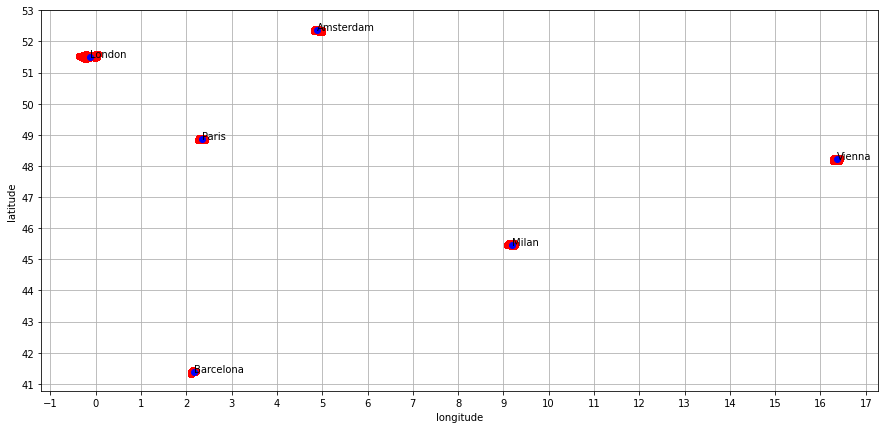

In [9]:
plt.figure(figsize=(15, 7))
plt.plot(hotel_reviews['lng'], hotel_reviews['lat'], 'ro')
for city in cities:
    location = geolocator.geocode(city)
    plt.plot(location.longitude, location.latitude, 'bo')
    plt.annotate(city, (location.longitude, location.latitude))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid()
plt.xticks(range(-1, 18))
plt.yticks(range(41, 54))
plt.show()

## Hotel reviews embeddings

For embeddings generation we are going to use TfIdf.

Before vectorization we want to lemmatize words in reviews for better results.

In [10]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ilyamezentsev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ilyamezentsev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Let's use only positive reviews.

In [11]:
hotel_positive_reviews = hotel_reviews.copy()
hotel_positive_reviews['Positive_Review'] = hotel_positive_reviews['Positive_Review'].replace('No Positive', np.nan)
hotel_positive_reviews = hotel_positive_reviews.dropna(subset=['Positive_Review']).reset_index(drop=True)
hotel_positive_reviews.shape

(479792, 17)

### Text lemmatization.

In [12]:
lemmatizer = WordNetLemmatizer()
tokenized_text = []

for sentence in tqdm(hotel_positive_reviews['Positive_Review'].values):
    tokenized_sentence = ' '.join([lemmatizer.lemmatize(x).lower() for x in word_tokenize(sentence)])
    tokenized_text.append(tokenized_sentence)
    
hotel_positive_reviews['Positive_Review_lemmatized'] = tokenized_text

  0%|          | 0/479792 [00:00<?, ?it/s]

### Text vectorization.

In [13]:
vectorizer = TfidfVectorizer(max_features=128, stop_words='english')
vectorized_text = vectorizer.fit_transform(hotel_positive_reviews['Positive_Review_lemmatized'].values).toarray()
vectorized_text.shape

(479792, 128)

Calculating the average review vector for each hotel.

In [14]:
hotel_names = hotel_positive_reviews['Hotel_Name'].unique()

final_vectors = np.zeros((len(hotel_names), vectorized_text.shape[1]))

for i, hotel_name in enumerate(tqdm(hotel_positive_reviews['Hotel_Name'].unique())):
    indexes = hotel_positive_reviews[hotel_positive_reviews['Hotel_Name'] == hotel_name].index
    final_vectors[i, :] = vectorized_text[indexes].mean(axis=0)

  0%|          | 0/1492 [00:00<?, ?it/s]

### Example

In [15]:
def prepare_text(review, vectorizer):
    tokenized_review = ' '.join([lemmatizer.lemmatize(x).lower() for x in word_tokenize(review)])
    return vectorizer.transform([tokenized_review]).toarray()

review_idx = 0
review = hotel_reviews['Positive_Review'][review_idx]
print(f'{hotel_reviews["Hotel_Name"][review_idx]}: {review}')

review_vector = prepare_text(review, vectorizer)
print(review_vector.shape)

Hotel Arena:  Only the park outside of the hotel was beautiful 
(1, 128)


In [16]:
hotel_names[np.linalg.norm(final_vectors - review_vector, axis=1).argmin()]

'Hotel Seven One Seven'

### Saving

Hotel embeddings.

In [17]:
vector_df = pd.DataFrame(final_vectors)

In [18]:
vector_df.to_csv(space_hosting_data_path / 'vectors-df.csv', header=False, index=False)

Hotel metadata.

In [19]:
metadata = pd.DataFrame({'Hotel_Name': hotel_names})

In [20]:
hotel2average_score = hotel_reviews.groupby('Hotel_Name')['Reviewer_Score'].mean().to_dict()
hotel2longitude = hotel_reviews.groupby('Hotel_Name')['lng'].mean().to_dict()
hotel2latitude = hotel_reviews.groupby('Hotel_Name')['lat'].mean().to_dict()

In [21]:
metadata['Average_Score'] = metadata['Hotel_Name'].map(hotel2average_score)
metadata['Longitude'] = metadata['Hotel_Name'].map(hotel2longitude)
metadata['Latitude'] = metadata['Hotel_Name'].map(hotel2latitude)

In [22]:
metadata['id'] = metadata.index

In [23]:
metadata.to_json(space_hosting_data_path / 'vectors-metadata.json', orient='records')

## Search in space-hosting

Now we need to run space-hosting.

1. We have already saved our vectors to directory `space-hosting/.data-samples`.
2. Now we need to run command `./docker-compose-up.sh` from directory `space-hosting`.

Let's imagine a user1 who pays attention on view from hotel room window, quality of breakfast and wants to relax. 
And user2 who wants to stay in hotel in quiet distrtict and is going to move to next destination after sleeping on comfortable bed.

Probably their search queries would look like that:

In [24]:
user_query1 = 'Hotel with beautiful view of old town, tasty breakfast and spa'
user_query2 = 'Hotel in quiet place, not far from train station and with huge bed'

We have to create a vector representation of the users' queries.

In [25]:
user_query_vector1 = prepare_text(user_query1, vectorizer)
user_query_vector2 = prepare_text(user_query2, vectorizer)

And then we search in space for vectors similar to users' query vectors.

In [26]:
headers = {"Content-Type": "application/json"}

body = json.dumps({
  "k": "5",
  "vectors": [
    {
      "isSparse": False,
      "dimension": user_query_vector1.shape[1],
      "coordinates": list(user_query_vector1[0])
    },
    {
      "isSparse": False,
      "dimension": user_query_vector2.shape[1],
      "coordinates": list(user_query_vector2[0])
    },
  ]
})

In [27]:
res = requests.post('http://localhost:8080/api/v1/Search', data=body, headers=headers)
res

<Response [200]>

Which hotels have most suitable reviews? Let's see

In [28]:
for user_query, data_points in zip([user_query1, user_query2], res.json()):
    print(f'For query "{user_query}" following hotels are recommended:')
    for data_point in data_points:
        print(data_point['data']['Hotel_Name'])
    print()

For query "Hotel with beautiful view of old town, tasty breakfast and spa" following hotels are recommended:
Austria Trend Hotel Schloss Wilhelminenberg Wien
Gran Hotel La Florida
Hotel Miramar Barcelona GL
Novotel London Canary Wharf
Shangri La Hotel at The Shard London

For query "Hotel in quiet place, not far from train station and with huge bed" following hotels are recommended:
AC Hotel Sants a Marriott Lifestyle Hotel
Barcel Sants
AZIMUT Hotel Vienna
Hotel Zeitgeist Vienna Hauptbahnhof
Urban Lodge Hotel

